# Predicting Hospital Readmission Rates Using Machine Learning Algorithms

# Executive Summary
The dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Information was extracted from the database for encounters that satisfied the following criteria.
(1)	It is an inpatient encounter (a hospital admission).
(2)	It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.
(3)	The length of stay was at least 1 day and at most 14 days.
(4)	Laboratory tests were performed during the encounter.
(5)	Medications were administered during the encounter.
The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.

The attribute information is given above : where the article talks about the :
Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records
https://www.hindawi.com/journals/bmri/2014/781670/

# Loading libraries required for the Data Analysis

In [241]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
from scipy.stats import norm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib.ticker import StrMethodFormatter
from matplotlib.legend_handler import HandlerLine2D

# Major libraries
import scipy
import bottleneck # for speeding up pandas operations
import numexpr # ditto
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Mining / EDA / dimensionality reduction
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

from sklearn.preprocessing import scale
from scipy.spatial.distance import euclidean
import scipy.stats as scs

# Supervised learning
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Unsupervised learning
from sklearn.cluster import DBSCAN, KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances
from matplotlib.colors import ListedColormap

# Understanding the data  : Data Wrangling

The outcome: Target [Dependent] variable is whether or not a patient was readmitted to a medical facility within 30 days. 
All other variables are predictors [Independent]
This project aims to determine which of the predictors are most useful in predicting the outcome.

In [242]:
#Reading the file

%matplotlib inline
import numpy as np
import pandas as pd 

pd.set_option('max_colwidth', 150)

#Read and print the top 5 values to have a look at the variables
readmit_df = pd.read_csv('E:\\Term 2\\Practicum\\dataset_diabetes\\diabetic_data.csv',encoding='utf-8')
readmit_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [243]:
#Checking the dimensions of the dataset
readmit_df.shape
#1,01,766 rows and 50 columns

(101766, 50)

In [244]:
#Initial change to the variable names to  make it well readable

#1. Changing time in hospital labeled a bit confusing as it displays the no of days for easier interpretation

readmit_df = readmit_df.rename(columns = {'time_in_hospital':'days_in_hospital'})

#2. The target variable to be predicted : readmission convert into binary (readmitted within 30 days or not)
readmit_df['readmitwithin30days'] = np.where(readmit_df['readmitted'] == '<30', 1, 0)


# Data Cleaning
1) Removing variables with high percentage of missing values
2) Removing data of those variables with low percentage of missing values
3) Removing observations that may cause bias

Duplicate rows exist meaning multiple entries for a patient in the data meaning they had more than one hospital visit, say folow-up visits. Keeping these rows could skew the results for the target variable towards such patients adding more weight. 
Keeping independent observations is an essential step in statistical analysis to rule out underlying relationships in the data For those reasons, it makes sense to keep each patient's first visit and drop the others.

Before removing these additional rows,we captured the number of encounters per patient as a new variable.
Patients who have had more visits to a medical facility may be more likely to be readmitted within 30 days, so let's make a new variable to indicate the number of visits for each patient before removing the additional encounters.

Also, removed observations that resulted in death or discharge to a hospice based on discharge_disposition_id, since such patients would not be eligible for readmission.

In [245]:
#Creating new variable that counts the total number of visits : duplicate entries against each patient
readmit_df['num_visits'] = readmit_df.groupby('patient_nbr')['patient_nbr'].transform('count')

#We see num_visits added in the end of the dataframe
readmit_df.sort_values(by = 'patient_nbr', ascending = True).head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,days_in_hospital,...,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,readmitwithin30days,num_visits
4267,24437208,135,Caucasian,Female,[50-60),?,2,1,1,8,...,No,No,No,No,No,Ch,Yes,<30,1,2
4780,26264286,135,Caucasian,Female,[50-60),?,1,1,7,3,...,No,No,No,No,No,Ch,Yes,>30,0,2
5827,29758806,378,Caucasian,Female,[50-60),?,3,1,1,2,...,No,No,No,No,No,No,No,NO,0,1
67608,189899286,729,Caucasian,Female,[80-90),?,1,3,7,4,...,No,No,No,No,No,No,Yes,NO,0,1
17494,64331490,774,Caucasian,Female,[80-90),?,1,1,7,3,...,No,No,No,No,No,Ch,Yes,NO,0,1


In [246]:
#Now, we proceed to data cleaning step

#Removing variables that may cause bias

#Reduce the df so that there's one encounter per patient . First, we sort and then drop duplicates : the subsequent rows

readmit_df_sorted = readmit_df.sort_values(['patient_nbr', 'encounter_id'])
readmit_df_unique = readmit_df_sorted.drop_duplicates(['patient_nbr'])

#Reducing the df furthermore by dropping encounters that resulted in death or discharge to hospice 

readmit_df1 = readmit_df_unique[((readmit_df_unique.discharge_disposition_id != 11) & 
                                          (readmit_df_unique.discharge_disposition_id != 13) &
                                          (readmit_df_unique.discharge_disposition_id != 14) & 
                                          (readmit_df_unique.discharge_disposition_id != 19) & 
                                          (readmit_df_unique.discharge_disposition_id != 20) & 
                                          (readmit_df_unique.discharge_disposition_id != 21))] 

readmit_df1.groupby('discharge_disposition_id').size()

discharge_disposition_id
1     44317
2      1539
3      8784
4       541
5       913
6      8289
7       409
8        73
9         9
10        6
12        2
15       40
16        3
17        8
18     2474
22     1410
23      260
24       25
25      778
27        3
28       90
dtype: int64

In [247]:
#Handling the missing data
#Creating a copy of the existing data frame because we need to replace question marks with NaN (which Python understands as NA). 

readmit_df2 = readmit_df1.copy() 
readmit_df2 = readmit_df2.replace('?', np.NaN) 
missing_values = readmit_df2.isnull().sum()/len(readmit_df2)*100 #Showing percentage of missing values
missing_values

encounter_id                 0.000000
patient_nbr                  0.000000
race                         2.741057
gender                       0.000000
age                          0.000000
weight                      96.015606
admission_type_id            0.000000
discharge_disposition_id     0.000000
admission_source_id          0.000000
days_in_hospital             0.000000
payer_code                  43.466766
medical_specialty           48.074257
num_lab_procedures           0.000000
num_procedures               0.000000
num_medications              0.000000
number_outpatient            0.000000
number_emergency             0.000000
number_inpatient             0.000000
diag_1                       0.014291
diag_2                       0.418733
diag_3                       1.749246
number_diagnoses             0.000000
max_glu_serum                0.000000
A1Cresult                    0.000000
metformin                    0.000000
repaglinide                  0.000000
nateglinide 

#From above, we clearly observe the following :
weight: 96% missing
medical specialty: 48% missing
payer code: ~44% missing
race: ~3% missing
diagnosis 3: ~2% missing

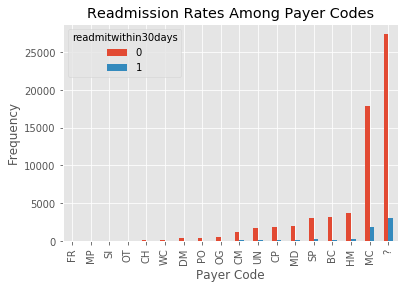

In [248]:
#Before removing the variables that have the highest no of missing values, let's check the following:

#Is our target variable even across the payer code variable , including the missing category? 

#Relationship between Payer Code and Readmission Rates

pay_code_ct = pd.crosstab(index = readmit_df1['payer_code'], columns = readmit_df1['readmitwithin30days'])
pay_code_df = pd.DataFrame(pay_code_ct.reset_index()).sort_values(by = 0)

#The ? indicates the missing category

levels = pay_code_df.payer_code.tolist()
mapping = {level: i for i, level in enumerate(levels)} #assign nos. to levels 
key = pay_code_df['payer_code'].map(mapping) #map level ordinals to their rows in df
sorting = pay_code_df.iloc[key.argsort()] #create df w/ desired order from matched ordinals
ax = sorting.plot(kind = 'bar', x = 'payer_code', title = 'Readmission Rates Among Payer Codes')
ax.set_xlabel('Payer Code')
ax.set_ylabel('Frequency')
plt.show()

As we see above, the balance of patients readmitted and not readmitted does not change very much across the different payer codes. There isn't much correlation of readmission depending on payer code, hence we drop this variable.
On similar lines, we drop the weight and the medical specialty columns.

In [249]:
#Drop readmitted column as we have created a derived variable out of it , weight, payer code, and medical specialty
readmit_df1 = readmit_df1.drop(['readmitted', 'weight', 'medical_specialty', 'payer_code'], axis = 1)

#Now, we look at the variables that have lower missing values 
race: ~3% missing
diagnosis 3: ~2% missing
Instead of removing the variable itself, we remove the observations with missing values for those variables.

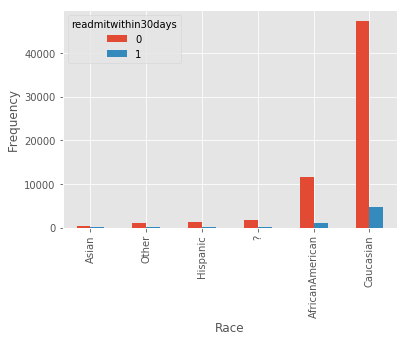

In [250]:
#Looking at relationship between race and readmissions

race_ct = pd.crosstab(index = readmit_df1['race'], columns = readmit_df1['readmitwithin30days'])
race_df = pd.DataFrame(race_ct.reset_index()).sort_values(by = 0)

    #make paired bar chart w/ race
Rlevels = race_df.race.tolist()
Rmapping = {level: i for i, level in enumerate(Rlevels)} #assign nos. to levels 
Rkey = race_df['race'].map(Rmapping) #map level ordinals to their rows in df
Rsorting = race_df.iloc[Rkey.argsort()] #create df w/ desired order from matched ordinals
ax1 = Rsorting.plot(kind = 'bar', x = 'race') 
ax1.set_xlabel('Race')
ax1.set_ylabel('Frequency')
plt.show()
#We see a consistence balance across different races. Of course, higher readmission rates for a specific race could be seen.
#Would be exploring and validating it as we go further.

In [251]:
#Remove the observations with low missing values .i.e. race and diagnosis 1, 2, and 3 (all have <1-2% of observations missing)
readmit_df1= readmit_df1[((readmit_df1.race != '?') &  (readmit_df1.diag_1 != '?') & (readmit_df1.diag_2 != '?') & (readmit_df1.diag_3 != '?'))]
readmit_df1.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,days_in_hospital,num_lab_procedures,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitwithin30days,num_visits
4267,24437208,135,Caucasian,Female,[50-60),2,1,1,8,77,...,Steady,No,No,No,No,No,Ch,Yes,1,2
5827,29758806,378,Caucasian,Female,[50-60),3,1,1,2,49,...,No,No,No,No,No,No,No,No,0,1
67608,189899286,729,Caucasian,Female,[80-90),1,3,7,4,68,...,No,No,No,No,No,No,No,Yes,0,1
17494,64331490,774,Caucasian,Female,[80-90),1,1,7,3,46,...,No,No,No,No,No,No,Ch,Yes,0,1
2270,14824206,927,AfricanAmerican,Female,[30-40),1,1,7,5,49,...,No,No,No,No,No,No,No,Yes,0,1


In [252]:
#Let's decode Numerical Values in Diagnostic Codes for : Diag 1, 2 & 3 for better interpretation
#First, we keep the code as it is except those which have columns prefixed with E or V : we equate this with a number say 9999

In [253]:
#Function to replace E or V to 9999
def first_letter(col):
    if (col[0] == 'E' or col[0] == 'V'):
        return '9999'
    else:
        return col

In [254]:
df1 = pd.DataFrame(readmit_df1.diag_1.apply(lambda col: first_letter(col)), dtype = 'float')
df2 = pd.DataFrame(readmit_df1.diag_2.apply(lambda col: first_letter(col)), dtype = 'float')
df3 = pd.DataFrame(readmit_df1.diag_3.apply(lambda col: first_letter(col)), dtype = 'float')

readmit_df1 = pd.concat([readmit_df1, df1, df2, df3], axis = 1)
#Adding new columns
readmit_df1.columns.values[48:51] = ('Diag1', 'Diag2', 'Diag3')
readmit_df1.head()
#The values have been replaced for  E and V and others have been kept as it is


,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,days_in_hospital,num_lab_procedures,...,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitwithin30days,num_visits,Diag1,Diag2,Diag3
4267,24437208,135,Caucasian,Female,[50-60),2,1,1,8,77,...,No,No,No,Ch,Yes,1,2,401.0,997.0,560.0
5827,29758806,378,Caucasian,Female,[50-60),3,1,1,2,49,...,No,No,No,No,No,0,1,722.0,305.0,250.0
67608,189899286,729,Caucasian,Female,[80-90),1,3,7,4,68,...,No,No,No,No,Yes,0,1,820.0,493.0,9999.0
17494,64331490,774,Caucasian,Female,[80-90),1,1,7,3,46,...,No,No,No,Ch,Yes,0,1,274.0,427.0,416.0
2270,14824206,927,AfricanAmerican,Female,[30-40),1,1,7,5,49,...,No,No,No,No,Yes,0,1,590.0,220.0,250.0


In [255]:
# We can now drop the older diagnosis variables
readmit_df1= readmit_df1.drop(['diag_1', 'diag_2', 'diag_3'], axis = 1)
readmit_df1.head(10)

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,days_in_hospital,num_lab_procedures,...,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitwithin30days,num_visits,Diag1,Diag2,Diag3
4267,24437208,135,Caucasian,Female,[50-60),2,1,1,8,77,...,No,No,No,Ch,Yes,1,2,401.0,997.0,560.00
5827,29758806,378,Caucasian,Female,[50-60),3,1,1,2,49,...,No,No,No,No,No,0,1,722.0,305.0,250.00
67608,189899286,729,Caucasian,Female,[80-90),1,3,7,4,68,...,No,No,No,No,Yes,0,1,820.0,493.0,9999.00
17494,64331490,774,Caucasian,Female,[80-90),1,1,7,3,46,...,No,No,No,Ch,Yes,0,1,274.0,427.0,416.00
2270,14824206,927,AfricanAmerican,Female,[30-40),1,1,7,5,49,...,No,No,No,No,Yes,0,1,590.0,220.0,250.00
18234,66197028,1305,Caucasian,Female,[60-70),3,1,1,9,52,...,No,No,No,No,Yes,0,1,491.0,428.0,250.01
15848,60254142,1314,Caucasian,Female,[40-50),2,1,1,2,50,...,No,No,No,No,Yes,0,3,996.0,411.0,401.00
61382,171414378,1629,Caucasian,Male,[70-80),3,6,4,14,21,...,No,No,No,No,Yes,0,1,9999.0,719.0,438.00
2279,14897280,2025,Caucasian,Female,[70-80),2,3,1,12,47,...,No,No,No,Ch,Yes,0,1,682.0,707.0,560.00
7866,36469686,3069,Caucasian,Male,[60-70),2,1,1,8,57,...,No,No,No,No,Yes,0,1,414.0,584.0,285.00


# Feature Engineering

The features Diagnosis-1, Diagnosis-2 and Diagnosis-3 refer to primary, secondary and additional diagnoses respectively and they correspond to the first three digits of ICD-9 codes.

Additionally, just Diagnosis-1 column has 848 distinct values, implying that it is important to collapse these into fewer sub-categories during the cleaning process by utilizing the categorization in ICD official website.

One special code to pay attention to is 250.xx which corresponds to Diabetes.

Encode diag_1 by ICD-9 Code
The 3 giagnose columns need to be re-coded in order to present useful information. Based on ICD-9 code, we re-coded ‘diag_1’ into 9 features which corresponds to 9 major primary diagnosis and one ‘other’ column.

"""ICD-9 Code Categories: https://icd.codes/icd9cm

** Diabetes: 250.xx

1) 001-139 : Infectious And Parasitic Diseases = Infection
2) 140-239 : Neoplasms = Neoplasms
3) 240-279 : Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders = Endocrine
4) 280-289 : Diseases Of The Blood And Blood-Forming Organs = Blood
5) 290-319 : Mental Disorders = Mental
6) 320-389 : Diseases Of The Nervous System And Sense Organs = Nervous
7) 390-459 : Diseases Of The Circulatory System = Circulatory
8) 460-519 : Diseases Of The Respiratory System = Respiratory
9) 520-579 : Diseases Of The Digestive System = Digestive
10) 580-629 : Diseases Of The Genitourinary System = Genitourinary
11) 630-679 : Complications Of Pregnancy, Childbirth, And The Puerperium = Pregnancy_Childbirth
12) 680-709 : Diseases Of The Skin And Subcutaneous Tissue = Skin
13) 710-739 : Diseases Of The Musculoskeletal System And Connective Tissue = Musculoskeletal
14) 740-759 : Congenital Anomalies = Congenital
15) 760-779 : Certain Conditions Originating In The Perinatal Period = Perinatal_Condition
16) 780-799 : Symptoms, Signs, And Ill-Defined Conditions = Symptoms
17) 800-999 : Injury And Poisoning = Injury_Poisoning
18) V01-V91 : Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services = Additional_Factors
19) E000-E999 : Supplementary Classification Of External Causes Of Injury And Poisoning = External_Cause """


In [256]:
# Function for one hot encoding
def cat_col(col):
    if (col >= 390) & (col <= 459) | (col == 785):
        return 'circulatory'
    elif (col >= 460) & (col <= 519) | (col == 786):
        return 'respiratory'
    elif (col >= 520) & (col <= 579) | (col == 787):
        return 'digestive'
    elif (col >= 250.00) & (col <= 250.99):
        return 'diabetes'
    elif (col >= 800) & (col <= 999):
        return 'injury'
    elif (col >= 710) & (col <= 739): 
        return 'musculoskeletal'
    elif (col >= 580) & (col <= 629) | (col == 788):
        return 'genitourinary'
    elif ((col >= 290) & (col <= 319) | (col == 7777) | 
          (col >= 280) & (col <= 289) | 
          (col >= 320) & (col <= 359) |
          (col >= 630) & (col <= 679) |
          (col >= 360) & (col <= 389) |
          (col >= 740) & (col <= 759)):
        return 'other'
    else:
        return 'neoplasms'

In [257]:
#The above function is now applied to the diag 1,2 & 3 columns
readmit_df1['diag_1_ICD'] = readmit_df1.Diag1.apply(lambda col: cat_col(col))
readmit_df1['diag_2_ICD'] = readmit_df1.Diag2.apply(lambda col: cat_col(col))
readmit_df1['diag_3_ICD'] = readmit_df1.Diag3.apply(lambda col: cat_col(col))
readmit_df1.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,days_in_hospital,num_lab_procedures,...,change,diabetesMed,readmitwithin30days,num_visits,Diag1,Diag2,Diag3,diag_1_ICD,diag_2_ICD,diag_3_ICD
4267,24437208,135,Caucasian,Female,[50-60),2,1,1,8,77,...,Ch,Yes,1,2,401.0,997.0,560.0,circulatory,injury,digestive
5827,29758806,378,Caucasian,Female,[50-60),3,1,1,2,49,...,No,No,0,1,722.0,305.0,250.0,musculoskeletal,other,diabetes
67608,189899286,729,Caucasian,Female,[80-90),1,3,7,4,68,...,No,Yes,0,1,820.0,493.0,9999.0,injury,respiratory,neoplasms
17494,64331490,774,Caucasian,Female,[80-90),1,1,7,3,46,...,Ch,Yes,0,1,274.0,427.0,416.0,neoplasms,circulatory,circulatory
2270,14824206,927,AfricanAmerican,Female,[30-40),1,1,7,5,49,...,No,Yes,0,1,590.0,220.0,250.0,genitourinary,neoplasms,diabetes


Removing variables like patient ID , encounter ID as these numbers do not help in prediction , we  drop them for our ongoing analysis. Then, we change the names of certain column headings that use hyphens, which Python doesn't read as part of a name. We'll change them to use underscores so that Python will read all column names smoothly.

In [258]:
#Drop numerical columns not to be used for prediction also , diag1, diag2 and diag3 as they are now encoded with textual data
readmit_df1 = readmit_df1.drop(['encounter_id', 'patient_nbr', 'Diag1', 'Diag2', 'Diag3'], axis = 1)

#Hyphenated columns to be renamed

readmit_df1.rename(columns={'glyburide-metformin': 'glyburide_metformin',
                       'glipizide-metformin': 'glipizide_metformin',
                       'glimepiride-pioglitazone': 'glimepiride_pioglitazone',
                       'metformin-rosiglitazone': 'metformin_rosiglitazone',
                       'metformin-pioglitazone': 'metformin_pioglitazone', }, inplace=True)
readmit_df1.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,days_in_hospital,num_lab_procedures,num_procedures,num_medications,...,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed,readmitwithin30days,num_visits,diag_1_ICD,diag_2_ICD,diag_3_ICD
4267,Caucasian,Female,[50-60),2,1,1,8,77,6,33,...,No,No,No,Ch,Yes,1,2,circulatory,injury,digestive
5827,Caucasian,Female,[50-60),3,1,1,2,49,1,11,...,No,No,No,No,No,0,1,musculoskeletal,other,diabetes
67608,Caucasian,Female,[80-90),1,3,7,4,68,2,23,...,No,No,No,No,Yes,0,1,injury,respiratory,neoplasms
17494,Caucasian,Female,[80-90),1,1,7,3,46,0,20,...,No,No,No,Ch,Yes,0,1,neoplasms,circulatory,circulatory
2270,AfricanAmerican,Female,[30-40),1,1,7,5,49,0,5,...,No,No,No,No,Yes,0,1,genitourinary,neoplasms,diabetes


Till now, we have made sure all the missing values are handled, data is cleaned, feature engineering is done. We can go ahead and do some insights and EDA on it and later move for modelling.

In [259]:
#Export the cleaned data

#change all remaining ?s to NaN : making sure all missing values are handled

null_values= readmit_df1.replace('?', np.NaN)

check_null = null_values.isnull().sum()
check_null

race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
days_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazone                0
tolazamide                  0
examide                     0
citoglipton                 0
insulin   

# Exploratory Data Analysis
a) Relationship among independent variables
b) Relationship of independent variables against the target variable [readmitted within 30 days]

Now, we look into relationships between variables in the above cleaned data set through plots and descriptive statistics.
These relationships include correlation, dependence, and other measures that may indicate predictive value.

Where appropriate, we can use inferential statistics (hypothesis tests or confidence intervals) to test the significance of trends that emerge initially. The results will give a sense of which variables could be most important in final analyses and may also point to an important issue called multicollinearity. This issue occurs when two independent variables provide very similar information, creating a sort of redundancy that needs to be addressed before final analyses.

In [260]:
# Let's look at how the readmitted [Target] variable is distributed
readmit_df1.groupby('readmitwithin30days').size()

#It's almost 10x : 1

#This ratio -- the outcome variable's balance -- illustrates the overall likelihood of being readmitted within 30 days

readmitwithin30days
0    60770
1     6074
dtype: int64

# Let's now look at how the independent variables are correlated with each other via scatter plots

If two variables provide very similar information, then one would likely need to removed so that the shared information 
isn't overly weighted. 

[Concept of Multicollinearity]

For example, if age and number of medications are highly correlated, they will bias the results
Here, we consider number of procedures, number of medications, number of emergencies, and number of visits to a medical facility -- all features that could correlate highly with each other.

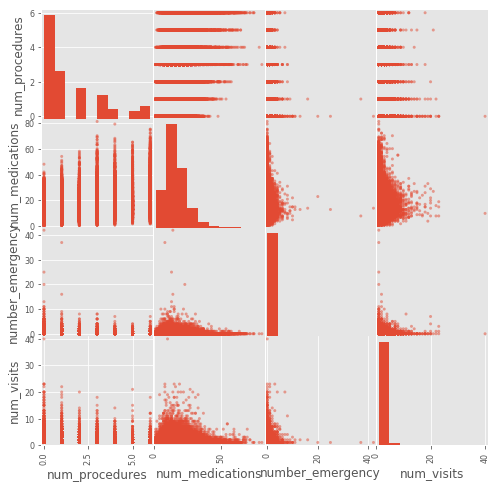

In [261]:
# Scatter matrix
sm = pd.scatter_matrix(readmit_df1[['num_procedures', 'num_medications', 'number_emergency', 'num_visits']], figsize = (8, 8))
sns.despine()

In a clear correlation, a sort of cigar-shaped, linear pattern with heavy clustering in the middle would appear on a plot. 

None of the above plots shows such a pattern, though, so multicollinearity is likely not an issue for any feature pairs here.

That said, it is worth noting that number of emergency admissions and number of medications show a curved, downward relationship, which indicates that these two variables may be exponentially -- though not linearly -- related. 
They appear to have a relationship, but it is not one that could indicate multicollinearity.

These plots show heavy clustering around low values, but little else in the way of convincing trends. Note that the plots resembling histograms (on the diagonal running from top left to bottom right) are for variables plotted against themselves, hence their unique appearances.

Next let's understand the age variable , how it is distributed ?

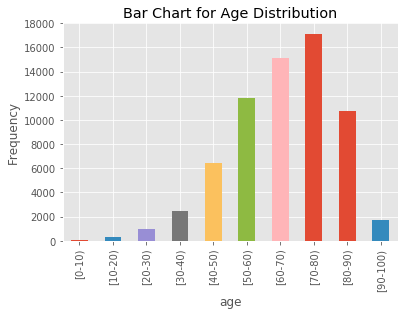

In [262]:
#Bar Chart
age_grouped = readmit_df1.groupby(['age']).size()
age_grouped.plot(kind = 'bar')
sns.despine()
plt.ylabel('Frequency')
plt.title('Bar Chart for Age Distribution')
plt.show()

Observations :
The patients skew older, so other variables that yield higher values for older patients could correlated highly with age and/or each other. Let's see if there is a relationship between age and our dependent variable, readmission within 30 days.

#Age vs Target Variable [ Readmission Rate]

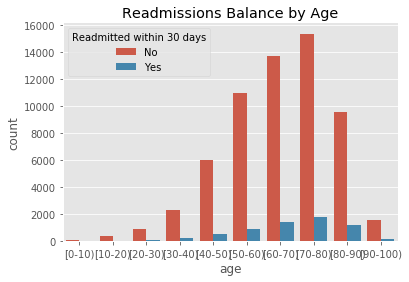

In [263]:
#Creating classes of intervals

age = readmit_df1.age.unique()
age.sort()
age_sort = np.array(age).tolist()

# paired bar plot to check b/w readmission within 30 days and age
plot_age= sns.countplot(x = 'age', hue = 'readmitwithin30days', data = readmit_df1, order = age_sort) 

sns.despine()
plot_age.legend(title = 'Readmitted within 30 days', labels = ('No', 'Yes'))
plot_age.axes.set_title('Readmissions Balance by Age')
plt.show()

Observations:
In general, the number of readmitted patients increases with the number of non-readmitted patients for each age group, so percentages of readmitted patients look similar across age groups. The percentages are not perfectly constant, however: the 80-90 age bracket clearly has a higher percentage of readmitted patients. Thus, there may be some predictive value in higher age brackets.

Next, it will help to look at possible correlation between age and number of medications; perhaps patients tend to need more medications as they get older.

#Age vs Number of Medications

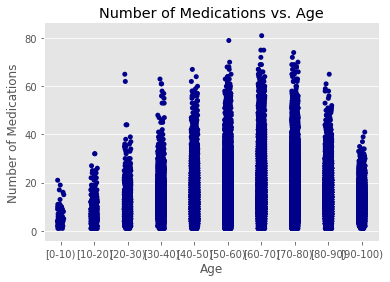

In [264]:
#make scatter plot for age and number of medications
age_sort = readmit_df1.sort_values(by = 'age')
g = sns.stripplot(x = "age", y = "num_medications", data = age_sort, color = 'darkblue')
sns.despine() #remove top and right axes

g.set_xlabel('Age')
g.set_ylabel('Number of Medications')
g.axes.set_title('Number of Medications vs. Age')
plt.show()

The scatter plot indicates that there are more people in higher age groups taking higher numbers of medications, but all age groups show heavy clustering in lower numbers, too. Therefore, it's unlikely that age and number of medications are so highly correlated that one variable would need removal.

Now let's see if there is an association between the number of days a patient spends in the in hospital and the number of procedures he or she has. If having more procedures done is simply a function of spending more days in the hospital, then one of these variables might be superfluous.

A grouped bar graph will help examine this relationship. For each number of days spent in the hospital, we can see how many patients had a certain number of procedures. If there are more patients having fewer procedures when spending fewer days in the hospital and vice versa, for example, there could be a correlation. (Note to viewer: you can zoom in/out and move around in the plot below using the grey icons that appear at the bottom left of the plot when you hover over it.)

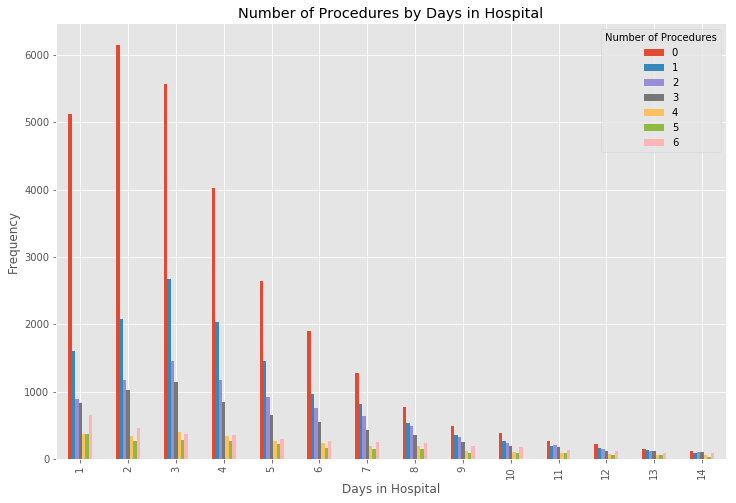

In [265]:
#cross tab and data frame for bar chart
num_procs_ct = pd.crosstab(index = readmit_df1['days_in_hospital'], columns = readmit_df1['num_procedures']) 
num_procs_df = pd.DataFrame(num_procs_ct.reset_index())


Nlevels = num_procs_df.days_in_hospital.tolist()
Nmapping = {level: i for i, level in enumerate(Nlevels)} #assign nos. to levels 
Nkey = num_procs_df['days_in_hospital'].map(Nmapping) #map level ordinals to their rows in df
Nsorting = num_procs_df.iloc[Nkey.argsort()] #create df w/ desired order from matched ordinals

p = Nsorting.plot(kind = 'bar', x = 'days_in_hospital', legend = 'Number of Procedures')
sns.despine()
p.figure.set_size_inches(12, 8)
p.set_xlabel('Days in Hospital')
p.set_ylabel('Frequency')
p.legend(title = 'Number of Procedures')
p.axes.set_title('Number of Procedures by Days in Hospital')
plt.show()

As the number of days in the hospital increases, frequency rises quickly before dropping swiftly for patients with lower numbers of procedures performed. However, the converse is not true: the frequency of patients with higher numbers of procedures does not increase with the number of days spent in the hospital. There is not much evidence for correlation or multicollinearity.

# Relationships Between Independent Variables and Readmission Within 30 Days

The initial researchers using this data set were interested in determining if patients who had HbA1c levels tested were significantly less likely to be readmitted within 30 days. As such, it's worth checking for correlation between HbA1c testing and readmission.

HbA1c result has four categories: 3 different levels and None, indicating that the test wasn't performed. The initial researchers looked at this variable as a categorical one in this fashion. Relevant percentages are calculated following the graph, and are all within 1% of those found by the original researchers.

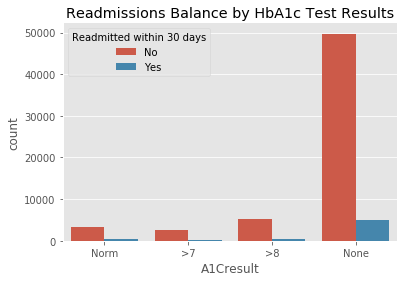

{'none': 9.192526163905681,
 '>7': 8.54978354978355,
 '>8': 8.556899877257585,
 'normal': 8.734107241569928}

In [266]:
# create plot and specifications 
A1C = sns.countplot(x = 'A1Cresult', hue = 'readmitwithin30days', data = readmit_df1, order = ['Norm', '>7', '>8', 'None']) 

sns.despine()

A1C.legend(title = 'Readmitted within 30 days', labels = ('No', 'Yes'))
A1C.axes.set_title('Readmissions Balance by HbA1c Test Results')
plt.show()

percents = {'none': 5033/(49718+5033)*100 , '>7': 237/(2535+237)*100, '>8': 488/(5215+488)*100, 'normal': 316/(3302+316)*100}
percents

#Observation :
#The graph and calculations above show a somewhat steady balance in readmissions across the levels of HbA1c tests, 
#so there may be evidence of correlation. 
#For more information, let's look at the data in binary format using a 2x2 table and a significance test for 
#independence between the two variables. The significance test will indicate whether a possible correlation could have 
#occurred by random chance.

In [267]:
#Note that in the table headings below, 0 indicates no and 1 indicates yes for the relevant variable.

#create new, binary column to show whether HbA1c test performed or not
readmit_df1['HbA1c'] = np.where(readmit_df1['A1Cresult'] == 'None', 0, 1)

#cross tab of HbA1c test and readmission w/in 30 days 
HbA1c_ct = pd.crosstab(index = readmit_df1['HbA1c'], columns = readmit_df1['readmitwithin30days'], margins = True)
HbA1c_ct

readmitwithin30days,0,1,All
HbA1c,,,
0,49718,5033,54751
1,11052,1041,12093
All,60770,6074,66844


In [268]:
#Calculations done based on the  matrix above :
#find readmission rates for patients who did and did not have HbA1c test, and for all patients
test = 1041/12093 * 100
no_test = 5033/54751 * 100

test, no_test

# Observation : 8.6% of tested patients were readmitted within 30 days, compared to 9.2% of non-tested patients.

(8.60828578516497, 9.192526163905681)

# The Chi-square test for independence will indicate if this difference is statistically significant, i.e., likely not due to chance.

In [269]:
#perform chi-square test for independence -- fix df row/col situation or use scipy approach w/ array-based table

def chisq_cols(df, c1, c2):
    groupsizes = df.groupby([c1, c2]).size()
    ctsum = groupsizes.unstack(c1) 
    return(scs.chi2_contingency(ctsum))

    #run test
    
chisq_cols(readmit_df1, 'HbA1c', 'readmitwithin30days')

(4.022262586746964,
 0.044903434870189884,
 1,
 array([[49775.87023517, 10994.12976483],
        [ 4975.12976483,  1098.87023517]]))

Observation :

Since the p-value from the test above is less than .05, we reject the null hypothesis that testing for HbA1c and readmission within 30 days are independent. More practically, this means that there is less than a 5% chance that this relationship is due to random chance. So even though the difference in percentages of readmitted patients for those tested and those not is fairly small, it is evidently not due to chance. HbA1c testing -- perhaps as a binary and as a multi-category outcome -- will be a key variable in final analyses.

Finally, since a new variable -- the number of visits by one patient to a medical facility -- was created, it would be nice to preview its relationship with the outcome variable. We'll do so using a paired bar chart again.


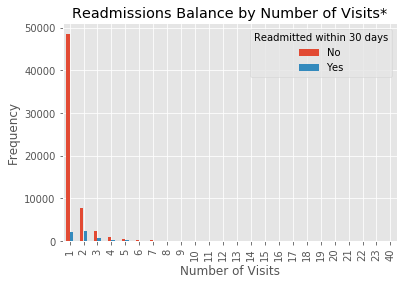

In [270]:
#No of Visits vs Frequency

#create cross-tab for initial evaluation and make data frame for bar plot
visits_ct = pd.crosstab(index = readmit_df1['num_visits'], columns = readmit_df1['readmitwithin30days'])
visits_df = pd.DataFrame(visits_ct.reset_index())

#make bar chart 
Vlevels = visits_df.num_visits.tolist()
Vmapping = {level: i for i, level in enumerate(Vlevels)} 
Vkey = visits_df['num_visits'].map(Vmapping) 
Vsorting = visits_df.iloc[Vkey.argsort()] 
v = Vsorting.plot(kind = 'bar', x = 'num_visits')
sns.despine()

v.set_xlabel('Number of Visits')
v.set_ylabel('Frequency')
v.legend(title = 'Readmitted within 30 days', labels = ('No', 'Yes'))
v.axes.set_title('Readmissions Balance by Number of Visits*')
plt.show()

With the exception of patients who had 2 visits, this graph shows an exponential, negative trend between readmissions frequency and number of hospital visits. This newly created variable may have predictive power.

Dealing with the Categorical Variables:
1) Binning the Number of lab procedures
2) One Hot encoding of all the categorical variables to perform the modelling

In [271]:
# bin mumber of lab procedures variable
 # write function
def bin_labs(col):
    if (col >= 1) & (col <= 10):
        return '[1-10]'
    if (col >= 11) & (col <= 20):
        return '[11-20]'
    if (col >= 21) & (col <= 30):
        return '[21-30]'
    if (col >= 31) & (col <= 40):
        return '[31-40]'
    if (col >= 41) & (col <= 50):
        return '[41-50]'
    if (col >= 51) & (col <= 60):
        return '[51-60]'
    if (col >= 61) & (col <= 70):
        return '[61-70]'
    if (col >= 71) & (col <= 80):
        return '[71-80]'
    if (col >= 81) & (col <= 90):
        return '[81-90]'
    if (col >= 91) & (col <= 100):
        return '[91-100]'
    if (col >= 101) & (col <= 110):
        return '[101-110]'
    if (col >= 111) & (col <= 120):
        return '[111-120]'
    else:
        return '[121-132]'
    
#Applying the function to this column:
# apply function to relevant variable, check df
readmit_df1['num_lab_procs'] = readmit_df1.num_lab_procedures.apply(lambda col: bin_labs(col))
readmit_df1.head()


# drop old lab-procedures variable
readmit_df1 = readmit_df1.drop(['num_lab_procedures'], axis = 1)

In [272]:
# change categorical variables from numeric to object where necessary
cols = readmit_df1[['admission_type_id', 'discharge_disposition_id', 'admission_source_id']] 
readmit_df1[['admission_type_id', 'discharge_disposition_id', 'admission_source_id']] = cols.astype(object)

# Mapping the Features
Before performing logistic regression, we need to map variables with text values to series of binary features. For example, suppose there are three admission types: A, B, and C. In the original admission-type column in the data set, each patient encounter would have A, B, or C. But machine-learning algorithms read binaries (and numerical categories, where appropriate) instead of letters and words. The encoding process creates two new columns: A and B. A patient encounter will have 1 in A and 0 in B to indicate admission type A. Converse encoding indicates type B, and a 0 in both columns indicates type C. This process is called one-hot encoding, and it will be helpful in other types of analysis like tree-based analysis as well.

In [273]:
# check variable types -- only integer and object
print(readmit_df1.dtypes.unique())

[dtype('O') dtype('int64') dtype('int32')]


In [274]:
# one-hot encoding for each object-column value
 # columns setting converts object and category dtypes; dropfirst creates n-1 dummies for n categories of a variable
readmit_model = pd.get_dummies(readmit_df1, columns = None, drop_first = True) 
readmit_model.head()

,days_in_hospital,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitwithin30days,num_visits,HbA1c,...,num_lab_procs_[111-120],num_lab_procs_[121-132],num_lab_procs_[21-30],num_lab_procs_[31-40],num_lab_procs_[41-50],num_lab_procs_[51-60],num_lab_procs_[61-70],num_lab_procs_[71-80],num_lab_procs_[81-90],num_lab_procs_[91-100]
4267,8,6,33,0,0,0,8,1,2,0,...,0,0,0,0,0,0,0,1,0,0
5827,2,1,11,0,0,0,3,0,1,0,...,0,0,0,0,1,0,0,0,0,0
67608,4,2,23,0,0,0,9,0,1,1,...,0,0,0,0,0,0,1,0,0,0
17494,3,0,20,0,0,0,9,0,1,1,...,0,0,0,0,1,0,0,0,0,0
2270,5,0,5,0,0,0,3,0,1,0,...,0,0,0,0,1,0,0,0,0,0


# Modelling : Logistic Regression
A logistic regression can be used when the outcome we are interested in is a categorical one. In this case, we are interested in whether or not a patient was readmitted within 30 days -- an outcome with two categories (yes or no).

In [275]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

Running the Logistic Regression and Checking Results
There a few things to note as this process happens. First, we'll read in the preprocessed data that has categorical features converted to separate, binary columns. Next, we'll split the data into a training and a test set. The training data is used to build the logistic model; it is the data that the model "learns" on. Once the model is constructed from the training data, we'll run it on the test data to make sure it generalizes -- or works on other data sets -- well. The test data was set aside before building the model precisely for this purpose.

In [276]:
# capture independent variables in list
features = list(readmit_model) 
features = [e for e in features if e not in ('Unnamed: 0', 'readmitwithin30days')]

In [277]:
# split the data into a training and test set
X = readmit_model[features].values
y = readmit_model.readmitwithin30days.values 
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = .2,random_state = 7, stratify = y)
#80-20 split
#Now that the data set is split, we can set up the regression and run it.

In [278]:
# create grid, run grid search w/ logistic regression, find best C and its accuracy score

C_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]} #dictionary w/ C as key and possible values
weights = {0: .1, 1: .9} # class weights to address imbalance of dependent variable 
clf_grid = GridSearchCV(LogisticRegression(penalty='l2', class_weight = weights), C_grid, 
                        cv = 5, scoring = 'accuracy') 
clf_grid.fit(Xtrain, Ytrain) #fit model on training data

print(clf_grid.best_params_, clf_grid.best_score_) #output best C and best accuracy score

{'C': 0.001} 0.8082842449742871


In [279]:
# check model accuracy on training data 
clf_grid_best = LogisticRegression(C = clf_grid.best_params_['C'], penalty='l2', 
                                    class_weight = weights)
clf_grid_best.fit(Xtrain, Ytrain)

x_pred_train = clf_grid_best.predict(Xtrain) #capture predictions for Y based on data in X
accuracy_score(x_pred_train, Ytrain)

0.8087143525011687

In [280]:
# check model accuracy on test data 
clf_grid_best.fit(Xtest, Ytest)
x_pred_test = clf_grid_best.predict(Xtest)
accuracy_score(x_pred_test, Ytest)

0.8237714114743062

In [281]:
# classification report for training data 
report_train = classification_report(Ytrain, x_pred_train) #classify actual Y values in test data vs. those predicted in X
print(report_train)

              precision    recall  f1-score   support

           0       0.95      0.84      0.89     48616
           1       0.24      0.52      0.33      4859

   micro avg       0.81      0.81      0.81     53475
   macro avg       0.59      0.68      0.61     53475
weighted avg       0.88      0.81      0.84     53475



In addition to accuracy, it often helps to check another metric called precision-recall. Precision-recall analysis reports various percentages for how well a model does at classifying observations accurately for an outcome. I'll talk about this more once we produce the numbers in classification reports below.

In [282]:
# classification report for training data 
report_train = classification_report(Ytrain, x_pred_train) #classify actual Y values in test data vs. those predicted in X
print(report_train)

              precision    recall  f1-score   support

           0       0.95      0.84      0.89     48616
           1       0.24      0.52      0.33      4859

   micro avg       0.81      0.81      0.81     53475
   macro avg       0.59      0.68      0.61     53475
weighted avg       0.88      0.81      0.84     53475



In [283]:
# classification report for test data
report_test = classification_report(Ytest, x_pred_test) 
print(report_test)

              precision    recall  f1-score   support

           0       0.95      0.86      0.90     12154
           1       0.26      0.50      0.34      1215

   micro avg       0.82      0.82      0.82     13369
   macro avg       0.60      0.68      0.62     13369
weighted avg       0.88      0.82      0.85     13369



Precision reflects the percentage of positive (i.e., readmitted within 30 days) predictions that are correct. If the model classifies 100 observations as positive, and 80 of those were in fact positive, then the model's precision is .8 (or 80%).

Recall captures the percent of true positives that are classified as positive. Returning to our model's context, if there were 1,000 patients readmitted within thirty days and the model detected 850 of them, then the model's recall would be .85 (or 85%).

Finally, the F1-score (the harmonic mean) shows the weighted average of precision and recall. It is a useful metric because it factors in both false positives and false negatives. The model here has an F1-score of .85, which is pretty good considering that 1.00 would be a perfect score and .5 would be as good as random guessing. However, this higher score masks the model's weak performance with positive cases.


A (theoretically) perfect ROC curve comprises a vertical line along the y-axis joined with a horizontal line at y = 1 (essentially an upside-down L. The closer our curve is to that ideal one, the better it is. So our model is looking pretty good at this point. Another line of comparison is the dotted red line, which represents at 50% success rate for binary predictions. If our model's line falls to this point, it is no better than randomly guessing would be.

In [284]:
# logistic regression with area under ROC curve as metric 
C_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]} 
clf_grid_ROC = GridSearchCV(LogisticRegression(penalty='l2', class_weight = weights), 
                            C_grid, cv = 5, scoring = 'roc_auc')
clf_grid_ROC.fit(Xtrain, Ytrain) 
print(clf_grid_ROC.best_params_, clf_grid_ROC.best_score_)

{'C': 0.01} 0.7845715578692758


In [285]:
# check ROC performance on training set
clf_grid_ROC_best = LogisticRegression(penalty='l2', class_weight = weights, 
                                       C = clf_grid_ROC.best_params_['C'])
clf_grid_ROC_best.fit(Xtrain, Ytrain)

probs_train = clf_grid_ROC_best.predict_proba(Xtrain)
preds_train = probs_train[:,1]
roc_auc_score(Ytrain, preds_train)

0.7899464250088466

In [286]:
# check ROC performance on test set 
clf_grid_ROC_best.fit(Xtest, Ytest)

probs_test = clf_grid_ROC_best.predict_proba(Xtest)
preds_test = probs_test[:,1]
roc_auc_score(Ytest, preds_test)

0.794785303285477

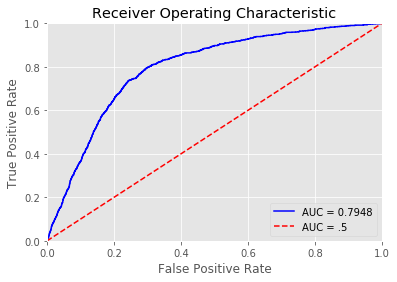

In [287]:
# plot ROC curve from test data
fpr, tpr, threshold = roc_curve(Ytest, preds_test) #find true- and false-positive rates for relevant decision thresholds
roc_auc = auc(fpr, tpr) #compute area under ROC curve using trapezoidal rule (not a binary classification here)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'blue', label = 'AUC = %0.4f' % roc_auc) #create line with AUC value for test data
plt.plot([0, 1], [0, 1],'r--', label = 'AUC = .5') #create line with AUC=.5 for comparison
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

A (theoretically) perfect ROC curve comprises a vertical line along the y-axis joined with a horizontal line at y = 1 (essentially an upside-down L. The closer our curve is to that ideal one, the better it is. So our model is looking pretty good at this point. Another line of comparison is the dotted red line, which represents at 50% success rate for binary predictions. If our model's line falls to this point, it is no better than randomly guessing would be.

# Confusion Matrix

In [288]:
# confusion matrix for training data
actual_train = pd.Series(Ytrain, name = 'Actual')
predict_train = pd.Series(x_pred_train, name = 'Predicted') 
train_ct = pd.crosstab(actual_train, predict_train, margins = True) 
print(train_ct)

Predicted      0      1    All
Actual                        
0          40707   7909  48616
1           2320   2539   4859
All        43027  10448  53475


In [289]:
# as percentages
TN_train = train_ct.iloc[0,0] / train_ct.iloc[0,2]
TP_train = train_ct.iloc[1,1] / train_ct.iloc[1,2]
print('Training accuracy for not readmitted: {}'.format('%0.3f' % TN_train))
print('Training accuracy for readmitted (Recall): {}'.format('%0.3f' % TP_train))

Training accuracy for not readmitted: 0.837
Training accuracy for readmitted (Recall): 0.523


In [290]:
# confusion matrix for test data
actual_test = pd.Series(Ytest, name = 'Actual')
predict_test = pd.Series(x_pred_test, name = 'Predicted') 
test_ct = pd.crosstab(actual_test, predict_test, margins = True) 
print(test_ct)

Predicted      0     1    All
Actual                       
0          10401  1753  12154
1            603   612   1215
All        11004  2365  13369


In [291]:
# as percentages
TN_test = test_ct.iloc[0,0] / test_ct.iloc[0,2]
TP_test = test_ct.iloc[1,1] / test_ct.iloc[1,2]
print('Test accuracy for not readmitted: {}'.format('%0.3f' % TN_test))
print('Test accuracy for readmitted (Recall): {}'.format('%0.3f' % TP_test))


Test accuracy for not readmitted: 0.856
Test accuracy for readmitted (Recall): 0.504


Observation :
The model does quite well predicting negative (labeled False in the matrices) cases, in which patients were not readmitted within thirty days. Percent accuracy is in the mid-80s. For positive cases, however, the model is just above 50% accuracy, which is just a little better than random chance. (You may also notice some overlap in the numbers here and those from the precision-recall part earlier.)